In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 100000000)
import warnings
warnings.filterwarnings("ignore")

## ¿Como interpretar este notebook?

Algunas definiciones útiles

`Observations`: Observación descriptiva de los datos

`Justification`: Tabla o gráfico que justifica una acción de los datos.

`Anomaly`: Anomalías encontradas en los datos.

## Problema abierto

- Se intenta responder una necesidad de negocio con un modelado predictivo. 

- ¿Que sabemos? La empresa es e-commerce y los las tablas representan caracterisiticas de usuarios y compras de los mismos

*Posibles soluciones*

- Forecasting: Predicr facturación
- **Clustering**: Segmentar usuarios en base a caracteristicas 
- Clasificación: Predecir productos comprados 

In [4]:
# Read Data
purchases = pd.read_csv('nsds_purchases.csv')
users = pd.read_csv('nsds_users.csv')

In [32]:
purchases.duplicated().value_counts()

False    134373
True       3047
dtype: int64

In [35]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137420 entries, 0 to 137419
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       137420 non-null  int64  
 1   purchased_at  137420 non-null  object 
 2   value         137420 non-null  float64
 3   product       137420 non-null  int64  
 4   product2      137420 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 5.2+ MB


`Observations`: 

- Dado que purchases es un dataset de transacciones, no nos interesa tener filas duplicadas ya que un transaccion ocurre una ves en el tiempo.

- Los tipos de datos son erroneos conforme al diccioanario de datos 

In [44]:
def change_dtypes(purchases:pd.DataFrame, users: pd.DataFrame):
    """ Basic functions to convert dtypes and remove duplicates

    Args:
        purchases (pd.DataFrame) 
        users (pd.DataFrame): 

    Returns:
        purchases (pd.DataFrame) 
        users (pd.DataFrame):

    """
    # Save a raw copy of data
    purchases_raw = purchases.copy()
    users_raw = users.copy()

    # Change datatype
    # Justification: According with the data dictionary some datetypes are wrong like product
    purchases['purchased_at'] = pd.to_datetime(purchases['purchased_at'])
    purchases['user_id'] = purchases['user_id'].astype(object) 
    purchases['product'] = purchases['product'].astype(object) 
    purchases['product2'] = purchases['product2'].astype(object) 
    purchases['value'] = purchases['value'].astype(float)
    
    #Drop duplicates
    #Justification: We are droping duplicates since this is a transactional dataset
    purchases = purchases.drop_duplicates()

    users['user_id'] = users['user_id'].astype(object)
    users['created_at'] = pd.to_datetime(users['created_at'])
    #users['birthyear'] = users['birthyear'].astype(int)
    users['gender'] = users['gender'].astype(object)
    users['maildomain'] = users['maildomain'].astype(object)
    users['region'] = users['region'].astype(object)
    users['orig_1'] = users['orig_1'].astype(object)
    users['orig_2'] = users['orig_2'].astype(object)
    users['utm_src'] = users['utm_src'].astype(object)
    users['utm_med'] = users['utm_med'].astype(object)
    users['utm_cpg'] = users['utm_cpg'].astype(object)
    users['channel'] = users['channel'].astype(object)
    users['is_active'] = users['is_active'].astype(object)

    return purchases, users


In [45]:
purchases, users = change_dtypes(purchases, users)

## EDA

Text(0.5, 1.0, 'Value distribution in purchases')

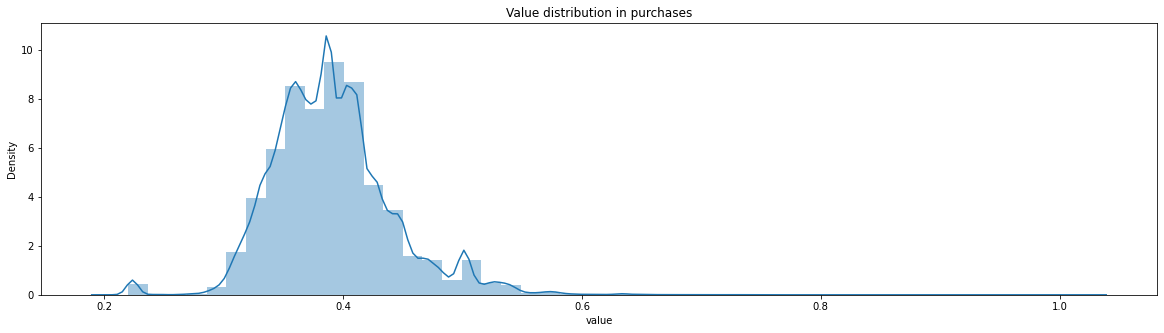

In [39]:
plt.figure(figsize=(20,5))
sns.distplot(purchases.value)
plt.title("Value distribution in purchases")


`Observations`:

- El valor de la facturación está ligeramente sesgado. Para un problema de regresión deberíamos connvertir la target en distribución log dado que el MSE asume que el target es una distribución normal.

In [46]:
purchases[purchases.value <=0 ]

,user_id,purchased_at,value,product,product2


`Observations`:

- No tenemos valores negativos.

<AxesSubplot:xlabel='purchased_at', ylabel='value'>

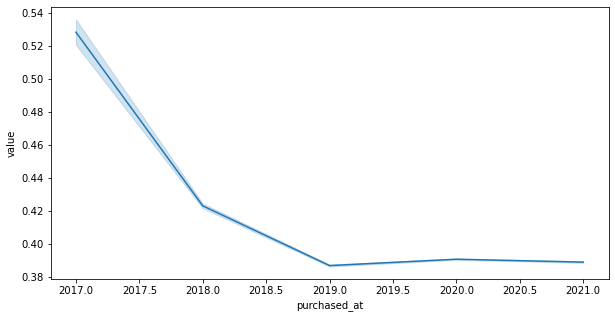

In [49]:
plt.figure(figsize = (10, 5))
sns.lineplot(x=purchases.purchased_at.dt.year, y="value",  data=purchases) 

`Observations`: 

- Esta gráfico es interesante. El valor de la facturación cae sobre los años. Este puede ser una buena pista para formular nuestra solución. 

¿Como se están comportando los productos y la facturación?

<AxesSubplot:xlabel='value', ylabel='Density'>

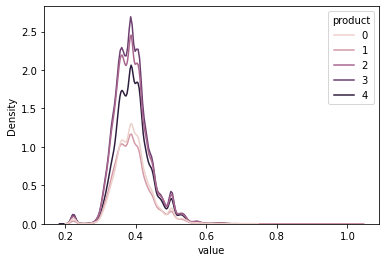

In [51]:
#purchases.head()
sns.kdeplot(purchases['value'], hue = purchases['product'])

<AxesSubplot:xlabel='value', ylabel='Density'>

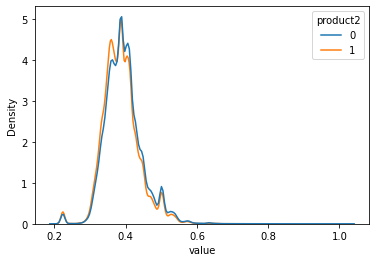

In [ ]:
sns.kdeplot(purchases['value'], hue = purchases['product2'])

`Observations`: 

- La distribución de la facturación no se desvÍa cuando la filtramos por los productos que la impactan. 

- Podemos observar que los productos 0 y 1 de la categoría product muestran menor densidad que el resto

- Si hicieramos un modelo de probabilidad de compra estos sería nuestros targets. Pero tendríamos un problema de desbalanceo


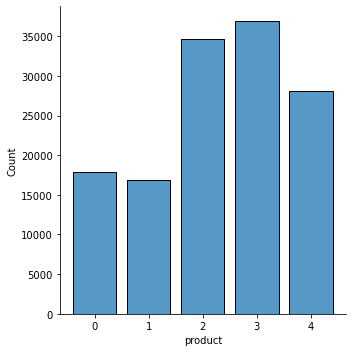

In [61]:
sns.displot(purchases, x="product", discrete=True, shrink=.8, bins= 100)

## Users

<AxesSubplot:xlabel='created_at', ylabel='user_id'>

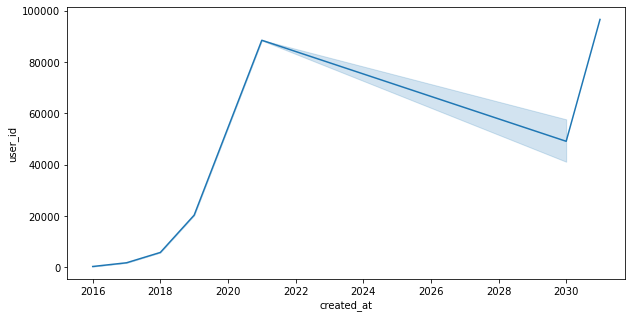

In [59]:
plt.figure(figsize = (10, 5))
sns.lineplot(x=users["created_at"].dt.year, y='user_id' ,data=users) 

`Observations`:

- Los usuarios tienen un estable crecimiento desde 2016 hasta el presente año.

`Anomaly`:

- Aunque vemos un ligero descenso de usuarios. Esta es una anomalía ya que no puede haber ningun usuario despues del presente año

<AxesSubplot:xlabel='birthyear'>

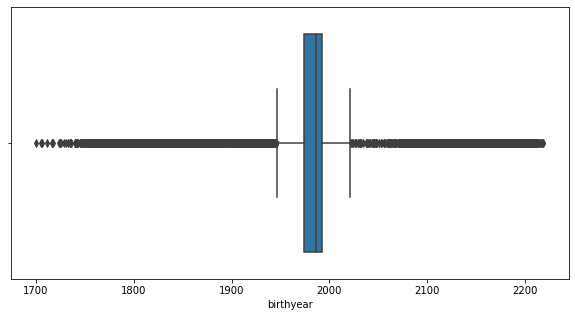

In [60]:
# birthyear

plt.figure(figsize = (10, 5))
sns.boxplot(users.birthyear) 

`Anomaly`:

- Hay claras anomalias en este dataset. No puede haber usuarios cuyo año de nacimiento sea 1700 o 2200.

- La acción que vamos a tomar va a ser un removal de outliers con el método de Tukey. 

In [63]:
# Remove outliers
from src.eda.preprocess import Preprocess
eda = Preprocess()

users['birthyear_is_outlier'] =  eda.detect_outliers_boxplot(data=users, features=['birthyear'])

# Remove outliers from dataset
users_1it = users[users['birthyear_is_outlier'] == False]

# Remove aux feature

users_1it = users_1it.drop('birthyear_is_outlier', axis=1)


lower threshold
birthyear    1945.5
dtype: float64
upper threshold
birthyear    2021.5
dtype: float64


In [64]:
# REMOVE ANOMALIES

#Remove anomalies
# a birthyear cannot be greater than created_year
users_1it = users_1it[(users_1it['created_at'].dt.year) >= (users_1it['birthyear']) ]

# Remove user created after the presente year 
users_1it = users_1it[users_1it['created_at'].dt.year <= 2022]



### Merge

In [65]:
### Merge
# Merge both tables with a inner join
byratings_1it = users_1it.merge(purchases, on=['user_id'], how='inner')


In [66]:
byratings_1it.shape

(75003, 23)

In [67]:
byratings_1it.select_dtypes(['object', 'category']).apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

user_id       21988
orig_2         1720
utm_cpg        1708
maildomain     1019
region          227
utm_src         145
orig_1          101
utm_med          13
channel          12
product           5
gender            2
is_active         2
product2          2
dtype: int64

In [68]:
eda.missing_values_table(byratings_1it)

Your selected dataframe has 23 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
orig_2,59043,78.7
gender,58616,78.2
utm_cpg,49553,66.1
utm_src,2687,3.6
utm_med,2684,3.6
orig_1,1361,1.8
channel,1136,1.5
region,191,0.3


`Observations`:


- En cuanto a variables categoricas tenemos un gran cantidad de dimensionalidad con ori_2, utm_cpg, maildomain.

- El top 3 de variables con valores nulos superan el 50% de el total de los datos.

In [70]:
byratings_1it[(byratings_1it['created_at']) > (byratings_1it['purchased_at'])].head(2)

,user_id,created_at,birthyear,gender,is_active,maildomain,region,orig_1,orig_2,utm_src,utm_med,utm_cpg,channel,dx_0,dx_1,dx_2,dx_3,gx,im,purchased_at,value,product,product2
7793,84973,2021-02-28 17:45:45,1995.0,NaN,0,2038,46.0,19.0,NaN,151.0,7.0,1712.0,4.0,56.169168,7.914518,38.057030,34.563815,-90.510152,0.106553,2021-02-28 06:38:51,0.428882,0,1
7834,89974,2021-04-30 22:10:48,2001.0,1.0,0,1787,214.0,6.0,NaN,NaN,NaN,NaN,NaN,36.802303,6.335209,43.824522,75.320524,20.933316,0.107058,2021-04-30 04:01:55,0.384419,4,1


`Anomaly`:

- Tenemos otra anomalía o corrupción en el dataset. Un usuario no puede haberse creado despues de haber hecho una compra.

In [71]:
#Let's get rid off records with purchases greater than creation of the user
#Remove anomaly
byratings_2it = byratings_1it[(byratings_1it['created_at']) <= (byratings_1it['purchased_at'])]

`Justification`: 

- Vamos a remover las 3 variables que previamente habiamos observado que tienen más del 50% de valores nulos.

De acuerdo con la descricpción:

*UTM Medium: Think of this as a channel. Social, Organic, Paid, Email, Affiliates, are all core marketing channels that include multiple traffic sources*.

- Vamos a remover utm_med y dejamos channel dado que los dos siginifican lo mismo y utm_med tiene más valores nulos que channel

In [72]:
features = byratings_2it.copy()


# There are 3 features with more than 50% of missing values. 
# Imputing those would only create bias in our data
# Drop top 3 features with >50% of missing values


features = features.drop(columns=['orig_2','gender', 'utm_cpg'], axis=1)

# Im going to erase utm_medium since it means the same as channel and utm_m has more missing values

features = features.drop('utm_med', axis=1)

In [72]:
features.select_dtypes(['object', 'category']).apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

user_id       21967
maildomain     1018
region          227
utm_src         144
orig_1          101
channel          12
product           5
is_active         2
product2          2
dtype: int64

### Con esta exploración podemos dar paso a la construcción de nuestra solución. 

Los principales insights enfocados a los dos KPIs importantes para una e-commerce (usuarios y transacciones) son:

- El crecimiento de usuarios se mantiene exponencial. No hay indicios de perdida o churn

- El nivel de facturación tiene un claro decenso con un ligero pico en 2020

Eligimos la aproximación clustering para hacer un profiling con un enfoque en facturación. De este modo podemos hacer estrategias de upselling y cross-selling para cada cluster

La estrategia de modelado sería:

- Construir variables con un perfil representativo de la transacción en el usuario. 

- Construir variables con perfil representativo de la facturación en cada canal UTM, dado que nos interesa saber los medios de las campañas y cuanto están facturando para saber en donde ubicamos mas esfuerzos. 

- Construir variables con un perfil representativo en la facturación para el resto de variables demograficas como "region"

- Para variables temporales nos limitamos solo a saber el año y el quarter. Con estas son suficientes para ubicar esfuerzos de venta en torno a por ejemplo fecha de alto trafico como Navidad o Black Friday

- Por último inferimos la edad de los usuarios creando restando el año de compra con el año de nacimiento




In [73]:
def feature_eng(features :pd.DataFrame):
    """Helper function that creates aggregated features of a given dataset

    Args:
        features (pd.DataFrame): 

    Returns:
        post_analisys: pandas Dataframe
        clustering_data: pandas Dataframe
        classification_data
    """

    # Time feature just quarter
    features['purchased_at_quarter'] = features['purchased_at'].dt.quarter
    features['purchased_at_year'] = features['purchased_at'].dt.year
    # Purchase age is a educated guess of the users age 
    features['purchase_age'] = features.apply(lambda x: x['purchased_at_year'] - x['birthyear'], axis=1)
    # Total value per user: strategy sum all values grouped per user
    features['user_total_value'] = features.groupby('user_id')['value'].transform("sum")
    # how long does an user take on average to buy 
    features['time_to_purchase'] = features['purchased_at'] - features['created_at']

    features['mean_time_to_purchase_per_user'] = features.groupby('user_id')['time_to_purchase'].transform("mean")
    #features['mean_time_to_purchase_per_user_days'] = features['mean_time_to_purchase_per_user_days'].dt.days

    # Min purchase time per user
    features['min_time_to_purchase_per_user'] = features.groupby('user_id')['time_to_purchase'].transform("min")
    #features['min_time_to_purchase_per_user_minute'] = features['min_time_to_purchase_per_user_minute'].dt.minute

    # Max purchases time per user
    features['max_time_to_purchase_per_user'] = features.groupby('user_id')['time_to_purchase'].transform("max")
    #features['max_time_to_purchase_per_user_days'] = features['max_time_to_purchase_per_user_days'].dt.days

    # How many purchases per user
    features['user_purchases'] = features.groupby('user_id')['value'].transform("count")

    # total_value_per_channel
    features['total_value_per_channel'] = features.groupby('channel')['value'].transform("sum")
    # total_value_per_region
    features['total_value_per_region'] = features.groupby('region')['value'].transform("sum")
    # total_value_per_utm_src
    features['total_value_per_utm_src'] = features.groupby('utm_src')['value'].transform("sum")
    # total_value_per_utm_src
    features['total_value_per_orig_1'] = features.groupby('orig_1')['value'].transform("sum")

    # Post Analysis Dataset
    post_analysis = features.copy()
    # Clustering dataset
    clustering_data = features.drop(columns= ['user_id','created_at', 'birthyear', 'purchased_at_year', 'purchased_at'])
    # Changing timedelta variables
    clustering_data['time_to_purchase'] = clustering_data['time_to_purchase'].dt.days#.astype('int')
    clustering_data['mean_time_to_purchase_per_user'] = clustering_data['mean_time_to_purchase_per_user'].dt.days#.astype('int')
    clustering_data['min_time_to_purchase_per_user'] = clustering_data['min_time_to_purchase_per_user'].dt.days#.astype('int')
    clustering_data['max_time_to_purchase_per_user'] = clustering_data['max_time_to_purchase_per_user'].dt.days#.astype('int')

    # Clasification dataset
    classification_data = clustering_data.copy()

    return post_analysis, clustering_data, classification_data



In [74]:
post_analysis, clustering_data, classification_data = feature_eng(features)

In [16]:
print(clustering_data.shape)
print(classification_data.shape)
print(post_analysis.shape)

(74906, 27)
(74906, 27)
(74906, 32)


In [17]:
clustering_data.select_dtypes(['object', 'category']).apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

maildomain    1018
region         227
utm_src        144
orig_1         101
channel         12
product          5
is_active        2
product2         2
dtype: int64

## Clustering. 

Algoritmo de elección: K-means

Dado que tenemos alta dimensionalidad en las variables categoricas. Se propone un enfoque basado en transformar los valores categoricos en númerico utilizando la frecuencia relativa de cada categoría en los atributos.


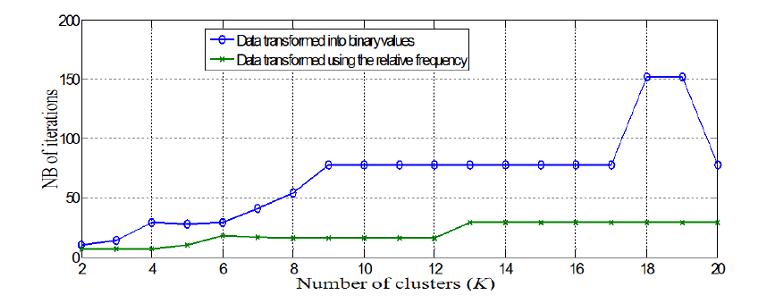

In [76]:
from IPython import display
display.Image("./cat_cluster.png")

En previas iteraciones se ha hecho una inicialización de número de clusters optimo con metodos estandar de K-value como la distorision (Elbow Method) y el Shilouette Coefficient

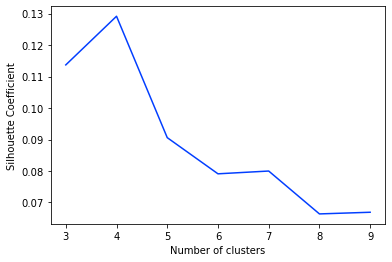

In [77]:
from IPython import display
display.Image("./silho.png")

Aunque siempre se puede hiperparametrizar el algoritmo. Nos basamos esta primera iteración en esta métrica y elegimos 4 clusters 

In [78]:
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import  StandardScaler

def clustering(df:pd.DataFrame, 
classification_data: pd.DataFrame, 
post_analysis: pd.DataFrame,):

    """ Functions that makes preprocessing steps for clustering and predicts clusters given any data

    Args:
        df (pd.DataFrame): 
        classification_data (pd.DataFrame): 
        post_analysis (pd.DataFrame): 

    Returns:
        classification_data:
        post_analysis
    """

    imputer = SimpleImputer(missing_values=np.nan, strategy= 'most_frequent')
    df[:] = imputer.fit_transform(df)

    # Encoding 
    df['region'] = df['region'].astype('category')
    df['utm_src'] = df['utm_src'].astype('category')
    df['maildomain'] = df['maildomain'].astype('category')
    df['channel'] = df['channel'].astype('category')
    df['product'] = df['product'].astype('category')
    df['product2'] = df['product2'].astype('category')
    df['is_active'] = df['is_active'].astype('category')

    encoder = CountFrequencyEncoder(encoding_method="frequency" )
    encoder.fit(df)
    df = encoder.transform(df)

    #Scaling
    scaler = StandardScaler()
    scaled_clustering = scaler.fit_transform(df)

    #Kmeans
    km_4 = KMeans(n_clusters=4,random_state=123)

    classification_data['cluster'] = km_4.fit_predict(scaled_clustering)
    #classification_data_1it = classification_data.drop(columns=['orig_1', 'maildomain'], axis=1)
    # Encoding clasifcation data
    #classification_data_2it = pd.get_dummies(classification_data_1it, drop_first=True)
    
    post_analysis['cluster'] = km_4.fit_predict(scaled_clustering)

    return classification_data, post_analysis




## Clasificación 

Con la función nos guardamos dos datasets

1. Dataset para clasificacion en donde vamos a utilizar nuestros clusters como variable target para obtener un nivel de interpretabilidad que nos ayude a sacar insights

2. Dataset para el analisis posterior. Este dataset tiene variables fuente como user_id que nos van a ayudar a hacer un analisis posterior de los clusters y las variables que más contribuyeron a su predicción 

In [79]:
classification_data_cl , post_analysis_cl = clustering(clustering_data, classification_data, post_analysis)

In [20]:
classification_data_cl.select_dtypes(['object', 'category']).apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

maildomain    1018
region         227
utm_src        144
orig_1         101
channel         12
product          5
is_active        2
product2         2
dtype: int64

`Justification`:

- Eliminamos orig_1 y maildomain por su complejidad de dimension y ademas por que no figuraron en iteraciones pasadas

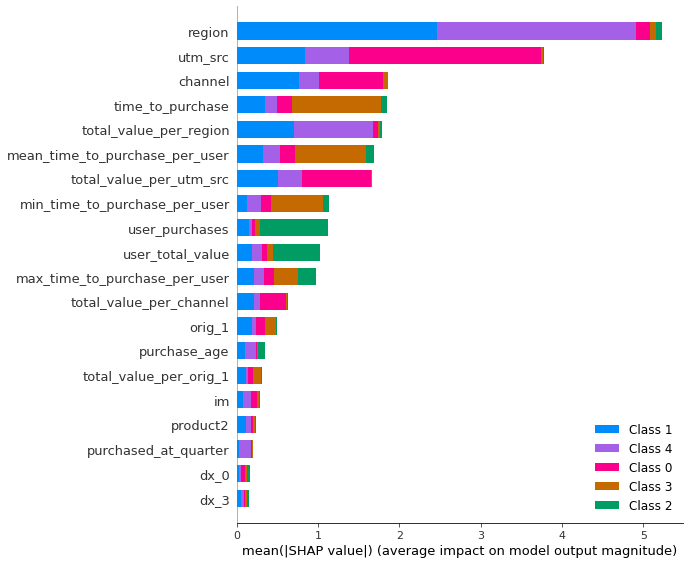

In [119]:
display.Image("./previious_shap.png")

In [123]:
classification_data_cl_1it = classification_data_cl.drop(columns=['orig_1', 'maildomain'], axis=1)

In [61]:
classification_data_cl_1it.select_dtypes(['object', 'category']).apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

region       227
utm_src      144
channel       12
product        5
is_active      2
product2       2
dtype: int64

Como metodo de codificación de variables categóricas para el problema de clasificación optamos por un one-hot encoding con dummy variables. Ya que particularmente nos interesa la interpretabilidad de la prediccón. Y una variable descriptora nos puede aportar información valiosa

In [124]:


classification_data_cl_2it = pd.get_dummies(classification_data_cl_1it, drop_first=True)


In [64]:
import shap
import lightgbm
from sklearn.model_selection import cross_val_score
    
X = classification_data_cl_2it.drop('cluster', axis=1)
y = classification_data_cl_2it['cluster']

clf = lightgbm.LGBMClassifier(class_weight='balanced', colsample_bytree=0.65, objective='multiclass')
scores = cross_val_score(clf, X, y, scoring='f1_weighted', cv=5)
print(f'F1 score is {scores.mean()}')

model = clf.fit(X, y)

    
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

F1 score is 0.9761919875306349


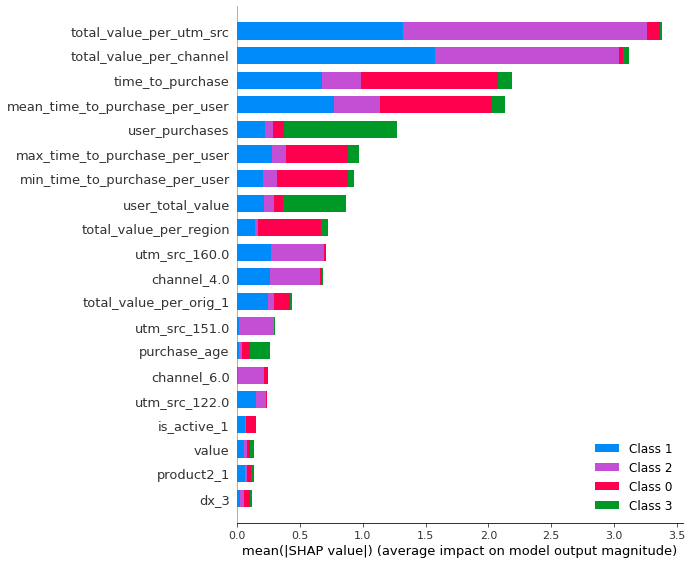

In [65]:
shap.summary_plot(shap_values, X)

## Post analysis Cluster 2

- Para el analísis del cluster 2 observamos que va enfocado a la facturación generada en el utm_src. Que es el parametro en donde se origino el trafico. Aqui podemos observar fuentes como facebooks, google etc.

In [77]:
post_analysis_cl2 = post_analysis[post_analysis['cluster'] == 2]

#utm
post_analysis_cl2_1it = post_analysis_cl2[['utm_src', 'value', 'purchase_age']]
# Create a total value pero utm in cluster 2
post_analysis_cl2_1it['total_value_per_utm_src_cl2'] = post_analysis_cl2_1it.groupby('utm_src')['value'].transform("sum")
post_analysis_cl2_1it['binned_age'] = pd.cut(post_analysis_cl2_1it.purchase_age, bins=np.linspace(20, 70, num = 11))

# What are the highes ton billing?
age_in_highest_utm_src = post_analysis_cl2_1it[['utm_src', 'total_value_per_utm_src_cl2', 'binned_age', 'value']]

age_in_highest_utm_src = age_in_highest_utm_src[(age_in_highest_utm_src['utm_src'] == 122.0) |(age_in_highest_utm_src['utm_src'] == 150.0) | (age_in_highest_utm_src['utm_src'] == 151.0) |
(age_in_highest_utm_src['utm_src'] == 160.0) | (age_in_highest_utm_src['utm_src'] == 196.0)]

<AxesSubplot:xlabel='utm_src', ylabel='total_value_per_utm_src_cl2'>

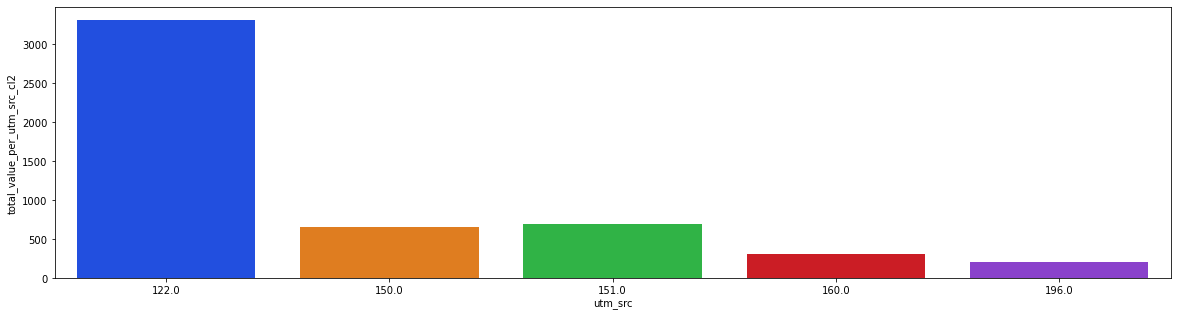

In [78]:
plt.figure(figsize=(20,5))
sns.set_palette("bright")
sns.barplot(x="utm_src", y="total_value_per_utm_src_cl2" ,data=post_analysis_cl2_1it[['utm_src','total_value_per_utm_src_cl2' ]].sort_values(by='total_value_per_utm_src_cl2', ascending = False).drop_duplicates().head(5)) 


- Hay una clara significancia en la facturación que está generando el 122.

- Aqui podemos ubicar que fuente es y hacer estrategias de upselling

<AxesSubplot:xlabel='binned_age', ylabel='percetage_of_binned_age_in_total_value_per_utm'>

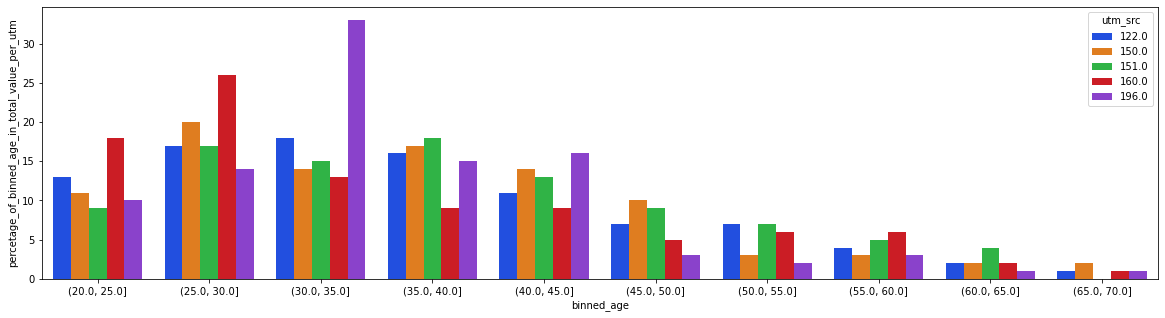

In [79]:
age_in_highest_utm_src['total_value_per_binned_age']= age_in_highest_utm_src.groupby(['binned_age', 'utm_src'])['value'].transform('sum')
age_in_highest_utm_src['percetage_of_binned_age_in_total_value_per_utm'] = round(age_in_highest_utm_src.total_value_per_binned_age / age_in_highest_utm_src.total_value_per_utm_src_cl2 *100 )

plt.figure(figsize=(20,5))
sns.set_palette("bright")
sns.barplot(x="binned_age", y="percetage_of_binned_age_in_total_value_per_utm" ,data=age_in_highest_utm_src, hue='utm_src') 


Para entender mejor la facturación en este parámetro. En esta gráfica podemos ver la contribucón en facturación por cada sector de usuarios en edad con respecto al total de facturación en cada utm. 

- Para el 122 que es el que tiene mayor facturación, podemos observar el rango de edad de 30 -35 es el más representativo.

- Sin embargo sobre para el utm de 196 el mismo rango de edad 30 -35 es el que contribuye más a la facturación

## Post Analysis Cluster 1

Las variables mas importantes para el cluster 1 es la facturación en la variable channel 


In [71]:
post_analysis_cl1 =  post_analysis[post_analysis['cluster'] == 1]
post_analysis_cl1_1it = post_analysis_cl1[['channel', 'value', 'purchase_age']]
#channel

post_analysis_cl1_1it['total_value_per_channel_cl1'] = post_analysis_cl1_1it.groupby('channel')['value'].transform("sum")

<AxesSubplot:xlabel='channel', ylabel='total_value_per_channel_cl1'>

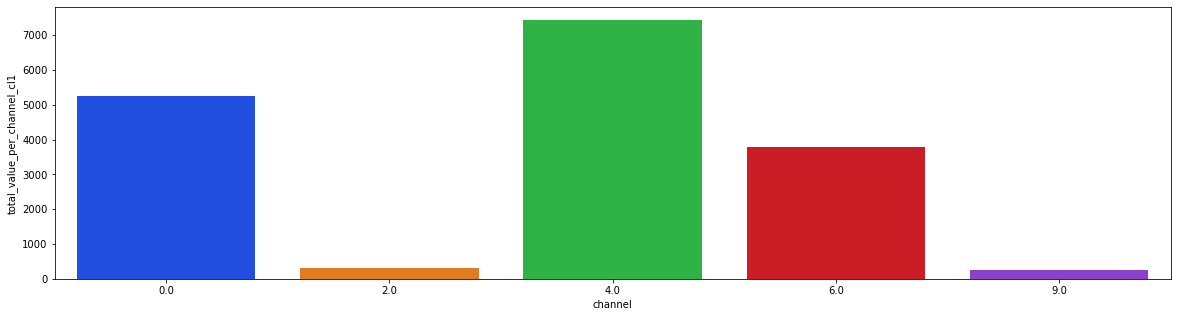

In [72]:
plt.figure(figsize=(20,5))
sns.set_palette("bright")
sns.barplot(x="channel", y="total_value_per_channel_cl1" ,data=post_analysis_cl1_1it[['channel','total_value_per_channel_cl1']].sort_values(by='total_value_per_channel_cl1', ascending = False).drop_duplicates().head(5)) 

- La observación más clara aqui es que el channel número 4 esta dando buenos resultados en facturación, seguido del channel número 0 y 6 


In [73]:
post_analysis_cl1_1it['binned_age'] = pd.cut(post_analysis_cl1_1it.purchase_age, bins=np.linspace(20, 70, num = 11))

age_in_highest_channels = post_analysis_cl1_1it[['channel', 'total_value_per_channel_cl1', 'binned_age', 'value']]

age_in_highest_channels = age_in_highest_channels[(age_in_highest_channels['channel'] == 0.0) |(age_in_highest_channels['channel'] == 2.0) | (age_in_highest_channels['channel'] == 4.0) |
(age_in_highest_channels['channel'] == 6.0) | (age_in_highest_channels['channel'] == 9.0)]


age_in_highest_channels['total_value_per_binned_age']= age_in_highest_channels.groupby(['binned_age', 'channel'])['value'].transform('sum')

age_in_highest_channels['percetage_of_binned_age_in_total_value_per_channel'] = round(age_in_highest_channels.total_value_per_binned_age / age_in_highest_channels.total_value_per_channel_cl1 *100,3 )

<AxesSubplot:xlabel='channel', ylabel='percetage_of_binned_age_in_total_value_per_channel'>

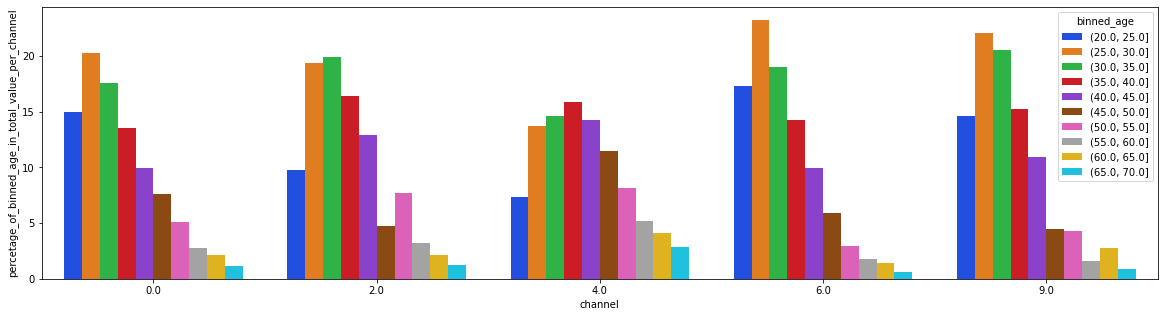

In [74]:
plt.figure(figsize=(20,5))
sns.set_palette("bright")
sns.barplot(x="channel", y="percetage_of_binned_age_in_total_value_per_channel" ,data=age_in_highest_channels, hue='binned_age') 

En este analisis podemos ver el porcentaje de contribución en de cada sector de edad con respecto al total de facturación de los channels con mayor facturación

- Para el channel con mayor facturación que es el 4 el sector de 35 - 40 es el mas representativo en facturación.

- Para el channel 6 y 9 el sector de los usuairos es más joven, rondan en la edad de 25 -30

Aqui claramente podemos ver que hay channels en donde los usuarios tienen mayor tráfico y por ende factuación.

## Post-Analysis Cluster 0

Observamos que las variables prinicipales con las relacionadas con el tiempo de compra.

Recordamos que el time_to_puchase se construyo apartir de el tiempo transcurrido entre la creación del usuario y la fecha de compra. 

Sobre esta premisa vamos a ver un par de graficos para saber más

In [80]:
post_analysis_cl0 = post_analysis[post_analysis['cluster'] == 0]

In [81]:
post_analysis_cl0_1it = post_analysis_cl2[['user_id','time_to_purchase', 'value', 'purchase_age',  'product', 'product2']]
post_analysis_cl0_1it['binned_age'] = pd.cut(post_analysis_cl0_1it.purchase_age, bins=np.linspace(20, 70, num = 11))

In [85]:
post_analysis_cl0_1it['mean_time_to_purchase_per_age'] = post_analysis_cl0_1it.groupby('binned_age')['time_to_purchase'].transform('mean')

In [95]:
product_timetopurchase =post_analysis_cl0_1it.groupby(['product', 'binned_age']).agg({'time_to_purchase':'mean'}).reset_index()

<AxesSubplot:xlabel='product', ylabel='time_to_purchase'>

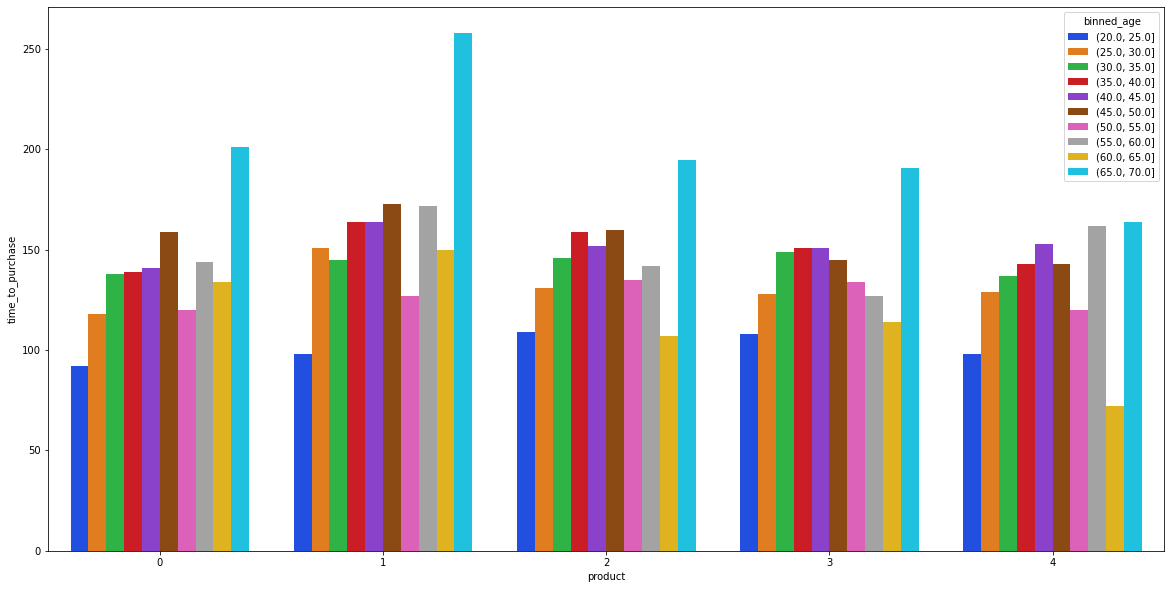

In [97]:
product_timetopurchase.head()
plt.figure(figsize=(20,10))
sns.set_palette("bright")
sns.barplot(x="product", y=product_timetopurchase.time_to_purchase.dt.days ,
data=product_timetopurchase, hue='binned_age') 

- Como primer insight podemos ver que el rango mas alto de edad es el que tarda más en comprar.

- Sin embargo para el producto 4 el rango de edad de 60 - 65 tiene una una significativa bajada en el tiempo promedio de compra. Aqui podemos alocar esfuerzos y lanzas campañas de marketing para este sector. 
 

<AxesSubplot:xlabel='product2', ylabel='time_to_purchase'>

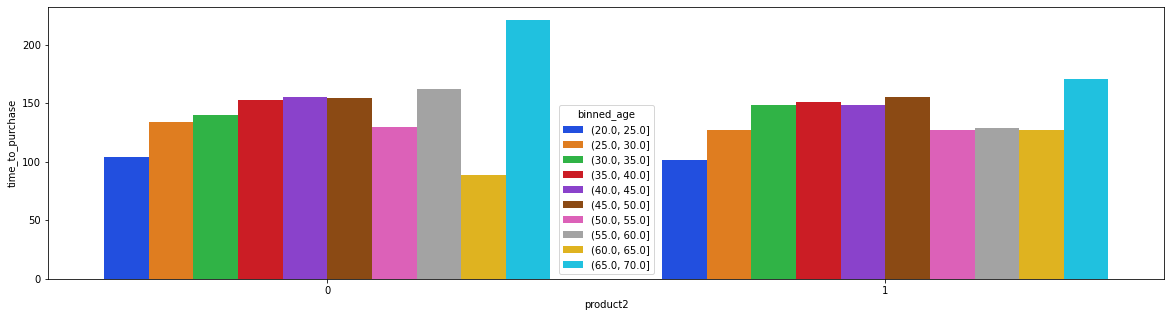

In [98]:
product2_timetopurchase =post_analysis_cl0_1it.groupby(['product2', 'binned_age']).agg({'time_to_purchase':'mean'}).reset_index()
plt.figure(figsize=(20,5))
sns.set_palette("bright")
sns.barplot(x="product2", y=product2_timetopurchase.time_to_purchase.dt.days ,
data=product2_timetopurchase, hue='binned_age') 

- Seguimos con la misma tendencia en usuarios que tienen edad de 65 - 70 para el tiempo de compra 

## Entorno de producción 

Se hizo análisis estático sobre el código cubriendo los siguientes paradigmas de convención:

- *Formatting*: Test realizado con `Black` y `Isort`

- *Linting*: Test realizado con `Flake8`

- *Documentation*: Test realizado con `Flake8 --docstrings`

- *Typing*: Test realizado con `mypy`

**Reproducibilidad**:

- Generar un entorno conda: `conda env create -f environment.yml`

**Siguientes pasos, futuro trabajo y recomendaciones**:

- A medida que el código base sea más dinámico se puede implementar el uso de `pre-commit hooks` para los tests mencionados previamente.

- Automatizar tests con `nox` así como añadir tests unitarios a medida de que el código lo vaya necesitando.

- Con el crecimiento en complejidad podemos ampliar la estructura del proyecto e ir añadiendo archivos de convención como `pyproject.toml`

- Con más conocimiento sobre el sistema de ingesta de datos y contexto de negocio podemos refactorizar el código haciendolo de propósito general.

- Es buena práctica también separar los requerimentos en desarrollo y producción `dev.txt`, `prod.text`.

- Ya sea con Github Actions o Jenkins podemos empezar con CI/CD.

- Si nos conectamos a una API, tenemos varias opciones: `Postman`, `FastAPI` 

**Siguientes pasos para el modelado**:

Clustering:

- Para el clustering se puede hacer un analisis exahustivo sobre la varianza con PCA.

- Utilizar diferentes métricas como `davies_bouldin_score` o `calinski_harabasz_score`.

- Utilizar otros modelos: `DBSCAN`, `AgglomerativeClustering`, `MeanShift`, `SpectralClustering`, `MiniBatchKMeans`, `AffinityPropagation`.

- Es imperativo crear un dataset entorno a los que queremos ver en nuestro clustering.

- Por último para un rápido prototipado podemos hacer una herramienta AutoML que este preparada para ingestar cualquier dataset y devolverte el mejor algoritmo. Pasando por un batería de algortimos y su respectiva hiperparametrización. Yo tengo un proyecto parecido ;)

Clasificación: 

- Dado que nos interesa la interpretabilidad en este caso de uso. Podemos indagar más con la batería de gráfico que `Shap` nos ofrece.

- Podemos tambien hacer un análisis de permutación de variables o importancia de variables para que nos ayuden a explicar clusters.

- Un analisis de la variaza explicada también puede bastar para la explicación de los clusters.

- Se puede hacer un hiperparametrización más extensiva. El código esta preparado para hacerla con la función `objective` 




# GRACIAS!